References:


*   https://www.kaggle.com/code/nawidsayed/lightgbm-and-cnn-3rd-place-solution/notebook
*   https://www.kaggle.com/code/mks2192/list-of-fake-samples-and-public-private-lb-split/notebook





### Imports

In [3]:
#pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
# from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
# import lightgbm as lightgbmclassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from tqdm import tqdm_notebook as tqdm
import scipy.ndimage
from sklearn import linear_model

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from skopt import BayesSearchCV

import warnings
warnings.filterwarnings('ignore')

In [6]:
RAND_STATE = 47
np.random.seed(RAND_STATE)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

### Data Exploration

In [7]:
folder ='../Downloads'

In [8]:
df = pd.read_csv(folder + '/train.csv')
test_df = pd.read_csv(folder + '/test.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../Downloads/train.csv'

In [8]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


### Basic Data Transformations and Aggregations

In [9]:
# There are no missing data in train and test datasets.
# Let's check the numerical values in train and test dataset.
df.info()

NameError: name 'df' is not defined

In [10]:
# imbalanced dataset
df['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

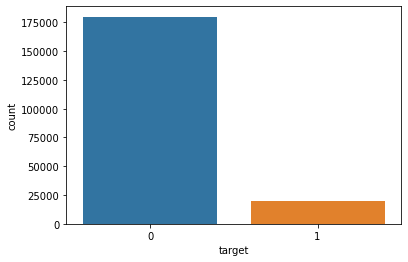

In [11]:
#df['target'].astype(str).hist()
sns.countplot(df['target'])

<AxesSubplot:>

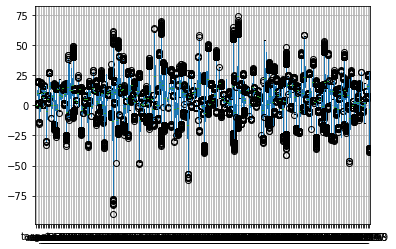

In [12]:
# Normalization to be done after predictor and target variable
# have been declared and populated

df.boxplot()

### Splitting real and fake test data

In [ ]:
test_df.drop(['ID_code'], axis=1, inplace=True)
test_df = test_df.values

unique_samples = []
unique_count = np.zeros_like(test_df)
for feature in tqdm(range(test_df.shape[1])):
    _, index_, count_ = np.unique(test_df[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print(len(real_samples_indexes))
print(len(synthetic_samples_indexes))

  0%|          | 0/200 [00:00<?, ?it/s]

100000
100000


In [ ]:
df_test_real = test_df[real_samples_indexes].copy()

generator_for_each_synthetic_sample = []
# Using 20,000 samples should be enough. 
# You can use all of the 100,000 and get the same results (but 5 times slower)
for cur_sample_index in tqdm(synthetic_samples_indexes[:20000]): #0
    cur_synthetic_sample = test_df[cur_sample_index]
    potential_generators = df_test_real == cur_synthetic_sample

    # A verified generator for a synthetic sample is achieved
    # only if the value of a feature appears only once in the
    # entire real samples set
    features_mask = np.sum(potential_generators, axis=0) == 1
    verified_generators_mask = np.any(potential_generators[:, features_mask], axis=1)
    verified_generators_for_sample = real_samples_indexes[np.argwhere(verified_generators_mask)[:, 0]]
    generator_for_each_synthetic_sample.append(set(verified_generators_for_sample))

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
indices_pub = generator_for_each_synthetic_sample[0]
for x in tqdm(generator_for_each_synthetic_sample):
    if indices_pub.intersection(x):
        indices_pub = indices_pub.union(x)

indices_pri = generator_for_each_synthetic_sample[1]
for x in tqdm(generator_for_each_synthetic_sample):
    if indices_pri.intersection(x):
        indices_pri = indices_pri.union(x)
        
print(len(indices_pub))
print(len(indices_pri))

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

50000
50000


In [ ]:
np.save(folder + 'public_LB.npy', list(indices_pub))
np.save(folder + 'private_LB.npy', list(indices_pri))
np.save(folder + 'synthetic_samples_indexes', list(synthetic_samples_indexes))

In [ ]:
test_df = pd.read_csv(folder + 'data/test.csv')

indices_fake = np.load(folder + 'synthetic_samples_indexes.npy')
indices_pub = np.load(folder + 'public_LB.npy')
indices_pri = np.load(folder + 'private_LB.npy')
indices_real = np.concatenate([indices_pub, indices_pri])

features = [c for c in df.columns if c not in ['ID_code', 'target']]
target_train = df['target']
X_train = df
X_test = test_df.loc[indices_real,:]
X_test['target'] = np.zeros(X_test.shape[0])
X_fake = test_df.loc[indices_fake,:]
X_fake['target'] = np.zeros(X_test.shape[0])
train_length = X_train.shape[0]
target_test = X_test['target']
target_fake = X_fake['target']

In [ ]:
X_all = pd.concat([X_train, X_test])
print(X_all.shape)

(300000, 202)


### Splitting real and fake train data

In [ ]:
sigma_fac = 0.001
sigma_base = 4

eps = 0.00000001

def get_count(X_all, X_fake):
    features_count = np.zeros((X_all.shape[0], len(features)))
    features_density = np.zeros((X_all.shape[0], len(features)))
    features_deviation = np.zeros((X_all.shape[0], len(features)))

    features_count_fake = np.zeros((X_fake.shape[0], len(features)))
    features_density_fake = np.zeros((X_fake.shape[0], len(features)))
    features_deviation_fake = np.zeros((X_fake.shape[0], len(features)))
    
    sigmas = []

    for i,var in enumerate(tqdm(features)):
        X_all_var_int = (X_all[var].values * 10000).round().astype(int)
        X_fake_var_int = (X_fake[var].values * 10000).round().astype(int)
        lo = X_all_var_int.min()
        X_all_var_int -= lo
        X_fake_var_int -= lo
        hi = X_all_var_int.max()+1
        counts_all = np.bincount(X_all_var_int, minlength=hi).astype(float)
        zeros = (counts_all == 0).astype(int)
        before_zeros = np.concatenate([zeros[1:],[0]])
        indices_all = np.arange(counts_all.shape[0])
        # Geometric mean of twice sigma_base and a sigma_scaled which is scaled to the length of array 
        sigma_scaled = counts_all.shape[0]*sigma_fac
        sigma = np.power(sigma_base * sigma_base * sigma_scaled, 1/3)
        sigmas.append(sigma)
        counts_all_smooth = scipy.ndimage.filters.gaussian_filter1d(counts_all, sigma)
        deviation = counts_all / (counts_all_smooth+eps)
        indices = X_all_var_int
        features_count[:,i] = counts_all[indices]
        features_density[:,i] = counts_all_smooth[indices]
        features_deviation[:,i] = deviation[indices]
        indices_fake = X_fake_var_int
        features_count_fake[:,i] = counts_all[indices_fake]
        features_density_fake[:,i] = counts_all_smooth[indices_fake]
        features_deviation_fake[:,i] = deviation[indices_fake]
        
    features_count_names = [var+'_count' for var in features]
    features_density_names = [var+'_density' for var in features]
    features_deviation_names = [var+'_deviation' for var in features]

    X_all_count = pd.DataFrame(columns=features_count_names, data = features_count)
    X_all_count.index = X_all.index
    X_all_density = pd.DataFrame(columns=features_density_names, data = features_density)
    X_all_density.index = X_all.index
    X_all_deviation = pd.DataFrame(columns=features_deviation_names, data = features_deviation)
    X_all_deviation.index = X_all.index
    X_all = pd.concat([X_all,X_all_count, X_all_density, X_all_deviation], axis=1)
    
    X_fake_count = pd.DataFrame(columns=features_count_names, data = features_count_fake)
    X_fake_count.index = X_fake.index
    X_fake_density = pd.DataFrame(columns=features_density_names, data = features_density_fake)
    X_fake_density.index = X_fake.index
    X_fake_deviation = pd.DataFrame(columns=features_deviation_names, data = features_deviation_fake)
    X_fake_deviation.index = X_fake.index
    X_fake = pd.concat([X_fake,X_fake_count, X_fake_density, X_fake_deviation], axis=1)    

    features_count = features_count_names
    features_density = features_density_names
    features_deviation = features_deviation_names
    return X_all, features_count, features_density, features_deviation, X_fake

In [ ]:
X_all, features_count, features_density, features_deviation, X_fake = get_count(X_all, X_fake)
print(X_all.shape)

  0%|          | 0/200 [00:00<?, ?it/s]

(300000, 802)


In [ ]:
features_to_scale = [features, features_count]
def get_standardized(X_all, X_fake):
    scaler = StandardScaler()
    features_to_scale_flatten = [var for sublist in features_to_scale for var in sublist]
    scaler.fit(X_all[features_to_scale_flatten])
    features_scaled = scaler.transform(X_all[features_to_scale_flatten])
    features_scaled_fake = scaler.transform(X_fake[features_to_scale_flatten])
    X_all[features_to_scale_flatten] = features_scaled
    X_fake[features_to_scale_flatten] = features_scaled_fake
    return X_all, X_fake

In [ ]:
X_all, X_fake = get_standardized(X_all, X_fake)

print(X_all.shape)

(300000, 802)


In [ ]:
X_train = X_all.iloc[:train_length,:]
X_test = X_all.iloc[train_length:,:]
del X_all
import gc
gc.collect()
X_train.to_csv(folder + 'X_train.csv')
X_test.to_csv(folder + 'X_test.csv')
print(X_train.shape, X_test.shape)

(200000, 802) (100000, 802)


## Get Updated Clean Files

In [10]:
# Use this for further analysis [802 cols]
df = pd.read_csv(folder + '/X_train.csv')
#test_df = pd.read_csv(folder + '/X_test.csv')
test_all_df = pd.read_csv(folder + '/X_test_all.csv')

In [11]:
test_all_df.shape

(200000, 803)

In [12]:
df.shape

(200000, 803)

In [13]:
test_all_df.head()

,Unnamed: 0,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,...,var_190_deviation,var_191_deviation,var_192_deviation,var_193_deviation,var_194_deviation,var_195_deviation,var_196_deviation,var_197_deviation,var_198_deviation,var_199_deviation
0,0,test_0,0.0,0.128505,2.324712,0.849615,1.288993,0.219077,0.340715,0.506504,...,1.697584,1.641985,5.003690,2.651668,1.133270,2.191341,2.556517,1.814695,1.111601,4.822515
1,1,test_1,0.0,-0.705823,0.712317,0.224697,-0.785061,-1.159928,0.133280,0.703056,...,2.454393,1.451071,1.226768,0.896390,1.359647,2.198263,1.231898,1.394803,1.134736,6.755367
2,2,test_2,0.0,-1.708813,-2.157008,-0.216449,0.125081,-0.502660,1.890337,-0.594904,...,0.948216,1.791584,1.130523,0.696292,3.388467,0.946695,1.450219,1.407064,1.193118,4.736953
3,3,test_3,0.0,-0.703519,0.075686,0.496547,-0.106108,-1.376838,1.047116,-0.543314,...,2.534827,0.529750,0.823941,0.975875,1.419152,1.904241,1.265501,0.930982,2.951023,0.957080
4,4,test_4,0.0,0.339193,0.369601,1.295271,0.468541,-1.217857,-0.448269,1.672429,...,1.180078,1.104552,1.169895,1.338118,1.744397,1.499995,1.676490,1.437243,0.686010,2.716664


In [17]:
# test set for internal model comparision
#X_test = test_df.iloc[:,3:]

In [14]:
# test set for kaggle competition
X_test_all = test_all_df.iloc[:,3:]

### Common processing


##### Train Test Data Split

In [15]:
# Splitting the training data into 
X_train, X_val, y_train, y_val = train_test_split(df.iloc[:, 3:],
                                                 df.target,
                                                 test_size=0.2, 
                                                 random_state=RAND_STATE,
                                                 stratify = df['target'])

In [16]:
# Creating a separate training data to be used in nested cross validation
X_train_cv = df.iloc[:, 3:]
print(X_train_cv.head())
print(X_train_cv.shape)

      var_0     var_1     var_2     var_3     var_4     var_5     var_6  \
0 -0.575796 -1.274446  0.453380 -0.830419  0.236351 -0.537108 -0.336720   
1  0.271663 -0.622372  1.192678 -0.685743  0.792506  1.539113  0.242780   
2 -0.679857 -0.276049  0.518718  0.538044 -0.305430 -0.511712  1.768455   
3  0.126794 -0.129301 -0.666880  0.197321  0.929709  0.409945  0.499002   
4 -0.275857  0.035855  0.819675 -0.075511  0.740067  0.954818  0.611763   

      var_7     var_8     var_9  ...  var_190_deviation  var_191_deviation  \
0  0.609622 -1.561258 -1.474508  ...           1.178042           3.230821   
1 -0.002261  0.859340  0.419449  ...           4.352000           1.363273   
2 -0.563125 -1.561048 -1.308044  ...           1.634016           1.751655   
3 -0.472635 -1.843593  0.548974  ...           0.723407           1.018349   
4  0.792299  1.795135  0.090005  ...           1.699548           2.352229   

   var_192_deviation  var_193_deviation  var_194_deviation  var_195_deviation  \

In [17]:
# Creating X_train and Y_train
Y_train_cv = df.target
Y_train_cv.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: target, dtype: float64

##### Create Inner and Outer CVs

In [18]:
def return_cv(folds = 5):
    inner_cv = KFold(n_splits=folds, shuffle=True, random_state=RAND_STATE)
    outer_cv = KFold(n_splits=folds, shuffle=True, random_state=RAND_STATE)
    return inner_cv, outer_cv

In [13]:
# We use balanced_accuracy as our metric 
# to choose the best model and hyperparameters
# scoring = 'balanced_accuracy'
inner_cv, outer_cv = return_cv(folds = 5)

### Charan - (Model - SVM)

In [ ]:
# Check for test data shape change

### Ankur - Logistic and Stacking


In [ ]:
#------------------- Logistic Regression Model -------------------
# Initializing the classifier
lr = linear_model.LogisticRegression()

# Creating a pipe using StandardScaler so that nested CV takes normalized data each time training set as 
# taken as input
# This is done so that there is no leakage of data from test to train set each time nested CV loops run
pipe_lr = Pipeline([('scaler', StandardScaler()), ('logreg', lr)])

# Setting up possible values of parameters (penalty, regularization strength and solver) to optimize over
p_grid_lr = {"logreg__penalty": ["l1", "l2", "elasticnet", "none"],
              "logreg__C": [10000, 1000, 100, 10, 1, 0.1],
            "logreg__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
             "logreg__class_weight": ['balanced']}

# Non_nested parameter search and scoring. Using estimator and parameter grid as the pipelined classifier
# and grid we initialized above
clf_lr = GridSearchCV(estimator=pipe_lr, param_grid=p_grid_lr, cv=inner_cv, scoring='roc_auc')
# clf_lr.fit(X_train_cv, Y_train_cv)
# non_nested_score_lr = clf_lr.best_score_

# Nested CV with parameter optimization
nested_score_lr = cross_val_score(clf_lr, X=X_train_cv, y=Y_train_cv, cv=outer_cv, scoring='roc_auc')
nested_score_lr = nested_score_lr.mean()

print("AUC from logistic regression on training dataset is: ", nested_score_lr)


### Sourabh - (LightGBM)

#### Running Light GBM without Nested CV for now!

In [ ]:
### Hyperparameter grid!
lgb_grid = {
    'model__bagging_freq': [5],
    'model__bagging_fraction': [0.331],
    'model__boost_from_average':['false'],
    'model__boost': ['gbdt'],
    'model__feature_fraction': [0.0405],
    'model__learning_rate': [0.0083],
    'model__max_depth': [-1],  
    #'model__metric':'auc',
    'model__min_data_in_leaf': [80],
    'model__min_sum_hessian_in_leaf': [10.0],
    'model__num_leaves': [13],
    'model__num_threads': [8],
    'model__tree_learner': ['serial'],
    'model__objective': ['binary'], 
    'model__class_weight': ['balanced'], #Class weight is balanced!
    'model__verbosity': [1]
    #'model__device': ['gpu']
}

#### Used 'AUC Score' as scoring since the final model performance is tested on auc score on kaggle!

In [ ]:
###Training the model!
new_model = Pipeline([('model', LGBMClassifier())])
clf_lgb = GridSearchCV(estimator=new_model, param_grid=lgb_grid, scoring = 'roc_auc')
clf_lgb.fit(X_train, y_train)
print(clf_lgb.best_score_)
print(clf_lgb.best_params_)
print(clf_lgb.best_estimator_)

0.8402783485729115
{'model__bagging_fraction': 0.331, 'model__bagging_freq': 5, 'model__boost': 'gbdt', 'model__boost_from_average': 'false', 'model__class_weight': 'balanced', 'model__feature_fraction': 0.0405, 'model__learning_rate': 0.0083, 'model__max_depth': -1, 'model__min_data_in_leaf': 80, 'model__min_sum_hessian_in_leaf': 10.0, 'model__num_leaves': 13, 'model__num_threads': 8, 'model__objective': 'binary', 'model__tree_learner': 'serial', 'model__verbosity': 1}
Pipeline(steps=[('model',
                 LGBMClassifier(bagging_fraction=0.331, bagging_freq=5,
                                boost='gbdt', boost_from_average='false',
                                class_weight='balanced',
                                feature_fraction=0.0405, learning_rate=0.0083,
                                min_data_in_leaf=80,
                                min_sum_hessian_in_leaf=10.0, num_leaves=13,
                                num_threads=8, objective='binary',
                    

Light GBM Classifier - Confusion Matrix


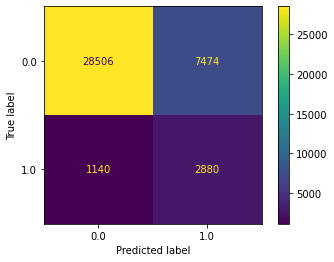

              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87     35980
         1.0       0.28      0.72      0.40      4020

    accuracy                           0.78     40000
   macro avg       0.62      0.75      0.63     40000
weighted avg       0.89      0.78      0.82     40000

Accuracy of the model:  0.78465
Recall of the model:  0.7164179104477612
Precision of the model:  0.27815337067799883
F Measure of the model:  0.4007235285932934


In [ ]:
### Testing the model on Validation set!
y_pred = clf_lgb.best_estimator_.predict(X_val)

print('Light GBM Classifier - Confusion Matrix')
plot_confusion_matrix(clf_lgb, X_val, y_val)
plt.show()

print(classification_report(y_val, y_pred))

print('Accuracy of the model: ',  accuracy_score(y_val, y_pred))
print('Recall of the model: ',    recall_score(y_val, y_pred))
print('Precision of the model: ', precision_score(y_val, y_pred))
print('F Measure of the model: ', f1_score(y_val, y_pred))

#### ROC AUC Curve!

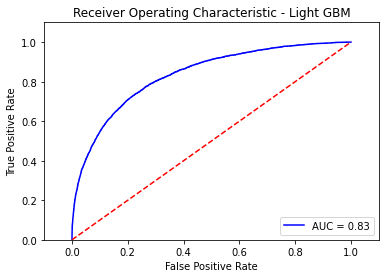

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = clf_lgb.predict_proba(X_val)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic - Light GBM')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
final_pred = clf_lgb.predict(X_test)

In [ ]:
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = final_pred
sub_df.to_csv("MSBA6420.Session002.submissionV2.csv", index=False)

### Anurag - (XGBoost)

In [14]:
# XGBoost model

xgbc_grid =  {
    'n_estimators': [50,100,200],
    'max_depth': [5, 10],
    'learning_rate': [0.05,0.1]
    
}

In [15]:
xgbc = XGBClassifier(verbosity = 2, 
                     learning_rate = 0.01,
                     scale_pos_weight = 8,
                     random_state = RAND_STATE)

In [26]:
# #pipe = Pipeline([('scaler', StandardScaler()), ('classifier', xgbc)])
# xgbc_clf = BayesSearchCV(estimator=xgbc, 
#                          search_spaces=xgbc_grid, 
# #                        cv=inner_cv, 
#                          scoring='roc_auc', 
#                          verbose = 1, 
#                          n_jobs = 3)

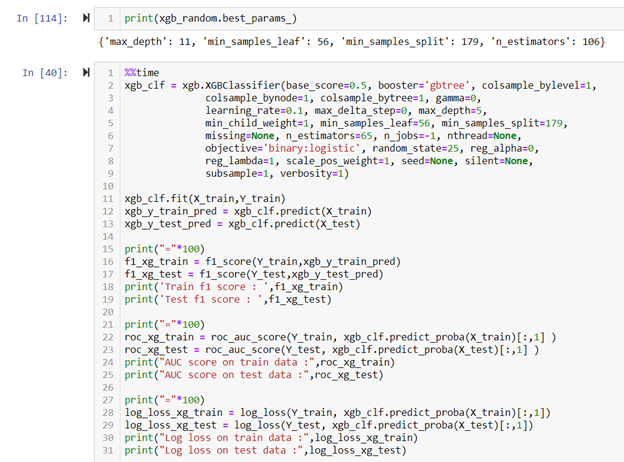

In [30]:
#xgbc_clf.fit(X_train, y_train, verbose = 1)

In [16]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
xgbc_clf = RandomizedSearchCV(scoring = 'roc_auc',
                       estimator = xgbc,
                       param_distributions = xgbc_grid,
                       verbose = 1,
                       n_iter = 2)

In [17]:
xgbc_clf.fit(X_train, y_train, 
            verbose = 1, 
            early_stopping_rounds = 3, 
            eval_metric = 'auc', 
            eval_set=[(X_train, y_train), 
                      (X_val, y_val)])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[20:59:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 880 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.73082	validation_1-auc:0.61880
[20:59:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 870 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.76932	validation_1-auc:0.64356
[20:59:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 988 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.80402	validation_1-auc:0.66272
[20:59:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 960 extr

[31]	validation_0-auc:0.94150	validation_1-auc:0.77622
[21:02:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1014 extra nodes, 0 pruned nodes, max_depth=10
[32]	validation_0-auc:0.94305	validation_1-auc:0.77732
[21:02:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 910 extra nodes, 0 pruned nodes, max_depth=10
[33]	validation_0-auc:0.94439	validation_1-auc:0.77847
[21:02:36] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 996 extra nodes, 0 pruned nodes, max_depth=10
[34]	validation_0-auc:0.94601	validation_1-auc:0.78016
[21:02:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 964 extra

[21:05:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 874 extra nodes, 0 pruned nodes, max_depth=10
[64]	validation_0-auc:0.96832	validation_1-auc:0.80559
[21:05:39] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 898 extra nodes, 0 pruned nodes, max_depth=10
[65]	validation_0-auc:0.96871	validation_1-auc:0.80671
[21:05:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1060 extra nodes, 0 pruned nodes, max_depth=10
[66]	validation_0-auc:0.96904	validation_1-auc:0.80706
[21:05:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1060 extra nodes, 0 pruned nodes, max_depth=10
[67]	validation_0

[95]	validation_0-auc:0.97591	validation_1-auc:0.82073
[21:08:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 976 extra nodes, 0 pruned nodes, max_depth=10
[96]	validation_0-auc:0.97605	validation_1-auc:0.82089
[21:08:34] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 916 extra nodes, 0 pruned nodes, max_depth=10
[97]	validation_0-auc:0.97619	validation_1-auc:0.82095
[21:08:39] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 966 extra nodes, 0 pruned nodes, max_depth=10
[98]	validation_0-auc:0.97631	validation_1-auc:0.82130
[21:08:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 824 extra 

[21:11:34] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 790 extra nodes, 0 pruned nodes, max_depth=10
[28]	validation_0-auc:0.93417	validation_1-auc:0.76555
[21:11:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 918 extra nodes, 0 pruned nodes, max_depth=10
[29]	validation_0-auc:0.93668	validation_1-auc:0.76712
[21:11:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 778 extra nodes, 0 pruned nodes, max_depth=10
[30]	validation_0-auc:0.93815	validation_1-auc:0.76924
[21:11:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 828 extra nodes, 0 pruned nodes, max_depth=10
[31]	validation_0-a

[21:14:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 856 extra nodes, 0 pruned nodes, max_depth=10
[60]	validation_0-auc:0.96633	validation_1-auc:0.79927
[21:14:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1070 extra nodes, 0 pruned nodes, max_depth=10
[61]	validation_0-auc:0.96697	validation_1-auc:0.79991
[21:14:39] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1052 extra nodes, 0 pruned nodes, max_depth=10
[62]	validation_0-auc:0.96750	validation_1-auc:0.80088
[21:14:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 760 extra nodes, 0 pruned nodes, max_depth=10
[63]	validation_0

[21:17:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1014 extra nodes, 0 pruned nodes, max_depth=10
[92]	validation_0-auc:0.97619	validation_1-auc:0.81539
[21:17:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 964 extra nodes, 0 pruned nodes, max_depth=10
[93]	validation_0-auc:0.97641	validation_1-auc:0.81595
[21:17:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 934 extra nodes, 0 pruned nodes, max_depth=10
[94]	validation_0-auc:0.97652	validation_1-auc:0.81633
[21:17:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1054 extra nodes, 0 pruned nodes, max_depth=10
[95]	validation_0

[21:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1084 extra nodes, 0 pruned nodes, max_depth=10
[24]	validation_0-auc:0.93101	validation_1-auc:0.76078
[21:20:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 838 extra nodes, 0 pruned nodes, max_depth=10
[25]	validation_0-auc:0.93348	validation_1-auc:0.76313
[21:20:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 808 extra nodes, 0 pruned nodes, max_depth=10
[26]	validation_0-auc:0.93562	validation_1-auc:0.76536
[21:20:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 938 extra nodes, 0 pruned nodes, max_depth=10
[27]	validation_0-

[21:23:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 936 extra nodes, 0 pruned nodes, max_depth=10
[56]	validation_0-auc:0.96656	validation_1-auc:0.80124
[21:23:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 934 extra nodes, 0 pruned nodes, max_depth=10
[57]	validation_0-auc:0.96704	validation_1-auc:0.80221
[21:23:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 798 extra nodes, 0 pruned nodes, max_depth=10
[58]	validation_0-auc:0.96744	validation_1-auc:0.80262
[21:23:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 850 extra nodes, 0 pruned nodes, max_depth=10
[59]	validation_0-a

[21:26:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 988 extra nodes, 0 pruned nodes, max_depth=10
[88]	validation_0-auc:0.97625	validation_1-auc:0.81921
[21:26:30] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1080 extra nodes, 0 pruned nodes, max_depth=10
[89]	validation_0-auc:0.97647	validation_1-auc:0.81917
[21:26:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 824 extra nodes, 0 pruned nodes, max_depth=10
[90]	validation_0-auc:0.97667	validation_1-auc:0.81938
[21:26:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 888 extra nodes, 0 pruned nodes, max_depth=10
[91]	validation_0-

[21:29:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 992 extra nodes, 0 pruned nodes, max_depth=10
[20]	validation_0-auc:0.92003	validation_1-auc:0.75312
[21:29:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 892 extra nodes, 0 pruned nodes, max_depth=10
[21]	validation_0-auc:0.92313	validation_1-auc:0.75535
[21:29:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 732 extra nodes, 0 pruned nodes, max_depth=10
[22]	validation_0-auc:0.92481	validation_1-auc:0.75885
[21:30:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 890 extra nodes, 0 pruned nodes, max_depth=10
[23]	validation_0-a

[21:33:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 942 extra nodes, 0 pruned nodes, max_depth=10
[52]	validation_0-auc:0.96211	validation_1-auc:0.79810
[21:33:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1084 extra nodes, 0 pruned nodes, max_depth=10
[53]	validation_0-auc:0.96290	validation_1-auc:0.79935
[21:33:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 934 extra nodes, 0 pruned nodes, max_depth=10
[54]	validation_0-auc:0.96358	validation_1-auc:0.80006
[21:33:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 920 extra nodes, 0 pruned nodes, max_depth=10
[55]	validation_0-

[83]	validation_0-auc:0.97404	validation_1-auc:0.81815
[21:36:30] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1032 extra nodes, 0 pruned nodes, max_depth=10
[84]	validation_0-auc:0.97433	validation_1-auc:0.81893
[21:36:36] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1066 extra nodes, 0 pruned nodes, max_depth=10
[85]	validation_0-auc:0.97460	validation_1-auc:0.81930
[21:36:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 966 extra nodes, 0 pruned nodes, max_depth=10
[86]	validation_0-auc:0.97480	validation_1-auc:0.81976
[21:36:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1054 ext

[21:39:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 810 extra nodes, 0 pruned nodes, max_depth=10
[16]	validation_0-auc:0.90528	validation_1-auc:0.74168
[21:39:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 944 extra nodes, 0 pruned nodes, max_depth=10
[17]	validation_0-auc:0.90990	validation_1-auc:0.74469
[21:39:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 638 extra nodes, 0 pruned nodes, max_depth=10
[18]	validation_0-auc:0.91183	validation_1-auc:0.74722
[21:40:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 952 extra nodes, 0 pruned nodes, max_depth=10
[19]	validation_0-a

[21:42:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1034 extra nodes, 0 pruned nodes, max_depth=10
[48]	validation_0-auc:0.95986	validation_1-auc:0.79358
[21:42:52] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 928 extra nodes, 0 pruned nodes, max_depth=10
[49]	validation_0-auc:0.96067	validation_1-auc:0.79478
[21:42:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 864 extra nodes, 0 pruned nodes, max_depth=10
[50]	validation_0-auc:0.96117	validation_1-auc:0.79597
[21:43:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 978 extra nodes, 0 pruned nodes, max_depth=10
[51]	validation_0-

[21:45:52] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 908 extra nodes, 0 pruned nodes, max_depth=10
[80]	validation_0-auc:0.97294	validation_1-auc:0.81565
[21:45:59] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1222 extra nodes, 0 pruned nodes, max_depth=10
[81]	validation_0-auc:0.97329	validation_1-auc:0.81605
[21:46:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 986 extra nodes, 0 pruned nodes, max_depth=10
[82]	validation_0-auc:0.97354	validation_1-auc:0.81631
[21:46:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 1148 extra nodes, 0 pruned nodes, max_depth=10
[83]	validation_0

[21:48:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[12]	validation_0-auc:0.74284	validation_1-auc:0.71954
[21:48:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[13]	validation_0-auc:0.74640	validation_1-auc:0.72290
[21:48:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[14]	validation_0-auc:0.75381	validation_1-auc:0.72825
[21:48:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15]	validation_0-auc:0.760

[21:49:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[44]	validation_0-auc:0.83549	validation_1-auc:0.79172
[21:49:59] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[45]	validation_0-auc:0.83650	validation_1-auc:0.79237
[21:50:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[46]	validation_0-auc:0.83745	validation_1-auc:0.79278
[21:50:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[47]	validation_0-auc:0.839

[21:51:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[76]	validation_0-auc:0.87019	validation_1-auc:0.81667
[21:51:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[77]	validation_0-auc:0.87130	validation_1-auc:0.81773
[21:51:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[78]	validation_0-auc:0.87221	validation_1-auc:0.81859
[21:51:34] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[79]	validation_0-auc:0.872

[21:52:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[108]	validation_0-auc:0.89216	validation_1-auc:0.83445
[21:52:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[109]	validation_0-auc:0.89249	validation_1-auc:0.83460
[21:53:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[110]	validation_0-auc:0.89304	validation_1-auc:0.83481
[21:53:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[111]	validation_0-auc:0

[21:54:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[140]	validation_0-auc:0.90725	validation_1-auc:0.84460
[21:54:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[141]	validation_0-auc:0.90781	validation_1-auc:0.84529
[21:54:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[142]	validation_0-auc:0.90832	validation_1-auc:0.84552
[21:54:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[143]	validation_0-auc:0

[21:55:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[172]	validation_0-auc:0.91888	validation_1-auc:0.85395
[21:55:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[173]	validation_0-auc:0.91911	validation_1-auc:0.85399
[21:55:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[174]	validation_0-auc:0.91956	validation_1-auc:0.85445
[21:56:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[175]	validation_0-auc:0

[21:57:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[4]	validation_0-auc:0.70050	validation_1-auc:0.68607
[21:57:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[5]	validation_0-auc:0.70559	validation_1-auc:0.68881
[21:57:36] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[6]	validation_0-auc:0.70771	validation_1-auc:0.69031
[21:57:39] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[7]	validation_0-auc:0.71205	v

[21:58:56] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[36]	validation_0-auc:0.82030	validation_1-auc:0.77743
[21:58:59] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[37]	validation_0-auc:0.82077	validation_1-auc:0.77760
[21:59:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[38]	validation_0-auc:0.82291	validation_1-auc:0.77929
[21:59:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[39]	validation_0-auc:0.824

[22:00:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[68]	validation_0-auc:0.86215	validation_1-auc:0.80953
[22:00:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[69]	validation_0-auc:0.86307	validation_1-auc:0.81035
[22:00:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[70]	validation_0-auc:0.86418	validation_1-auc:0.81142
[22:00:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[71]	validation_0-auc:0.865

[22:01:39] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[100]	validation_0-auc:0.88685	validation_1-auc:0.82966
[22:01:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[101]	validation_0-auc:0.88737	validation_1-auc:0.82972
[22:01:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[102]	validation_0-auc:0.88788	validation_1-auc:0.82998
[22:01:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[103]	validation_0-auc:0

[22:03:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[132]	validation_0-auc:0.90339	validation_1-auc:0.84257
[22:03:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[133]	validation_0-auc:0.90379	validation_1-auc:0.84270
[22:03:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[134]	validation_0-auc:0.90421	validation_1-auc:0.84306
[22:03:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[135]	validation_0-auc:0

[22:04:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[164]	validation_0-auc:0.91569	validation_1-auc:0.85138
[22:04:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[165]	validation_0-auc:0.91606	validation_1-auc:0.85163
[22:04:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[166]	validation_0-auc:0.91639	validation_1-auc:0.85207
[22:04:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[167]	validation_0-auc:0

[22:06:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[196]	validation_0-auc:0.92516	validation_1-auc:0.85847
[22:06:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[197]	validation_0-auc:0.92539	validation_1-auc:0.85866
[22:06:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[198]	validation_0-auc:0.92546	validation_1-auc:0.85870
[22:06:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[199]	validation_0-auc:0

[22:07:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[28]	validation_0-auc:0.80520	validation_1-auc:0.76787
[22:07:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[29]	validation_0-auc:0.80834	validation_1-auc:0.77051
[22:08:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[30]	validation_0-auc:0.80946	validation_1-auc:0.77134
[22:08:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[31]	validation_0-auc:0.813

[22:09:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[60]	validation_0-auc:0.85498	validation_1-auc:0.80765
[22:09:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[61]	validation_0-auc:0.85614	validation_1-auc:0.80844
[22:09:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[62]	validation_0-auc:0.85711	validation_1-auc:0.80929
[22:09:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[63]	validation_0-auc:0.858

[22:10:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[92]	validation_0-auc:0.88237	validation_1-auc:0.82787
[22:10:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[93]	validation_0-auc:0.88314	validation_1-auc:0.82844
[22:10:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[94]	validation_0-auc:0.88359	validation_1-auc:0.82881
[22:11:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[95]	validation_0-auc:0.884

[22:12:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[124]	validation_0-auc:0.89969	validation_1-auc:0.84093
[22:12:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[125]	validation_0-auc:0.90022	validation_1-auc:0.84130
[22:12:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[126]	validation_0-auc:0.90058	validation_1-auc:0.84141
[22:12:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[127]	validation_0-auc:0

[22:13:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[156]	validation_0-auc:0.91344	validation_1-auc:0.85138
[22:13:46] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[157]	validation_0-auc:0.91371	validation_1-auc:0.85148
[22:13:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[158]	validation_0-auc:0.91392	validation_1-auc:0.85169
[22:13:52] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[159]	validation_0-auc:0

[22:15:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[188]	validation_0-auc:0.92302	validation_1-auc:0.85796
[22:15:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[189]	validation_0-auc:0.92333	validation_1-auc:0.85820
[22:15:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[190]	validation_0-auc:0.92348	validation_1-auc:0.85829
[22:15:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[191]	validation_0-auc:0

[22:16:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[20]	validation_0-auc:0.78078	validation_1-auc:0.74741
[22:16:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[21]	validation_0-auc:0.78383	validation_1-auc:0.74983
[22:16:52] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[22]	validation_0-auc:0.78622	validation_1-auc:0.75160
[22:16:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23]	validation_0-auc:0.791

[22:18:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[52]	validation_0-auc:0.84685	validation_1-auc:0.79854
[22:18:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[53]	validation_0-auc:0.84837	validation_1-auc:0.79966
[22:18:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[54]	validation_0-auc:0.84975	validation_1-auc:0.80080
[22:18:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[55]	validation_0-auc:0.850

[22:19:36] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[84]	validation_0-auc:0.87719	validation_1-auc:0.82263
[22:19:39] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[85]	validation_0-auc:0.87823	validation_1-auc:0.82356
[22:19:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[86]	validation_0-auc:0.87902	validation_1-auc:0.82428
[22:19:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[87]	validation_0-auc:0.879

[22:21:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[116]	validation_0-auc:0.89653	validation_1-auc:0.83811
[22:21:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[117]	validation_0-auc:0.89679	validation_1-auc:0.83829
[22:21:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[118]	validation_0-auc:0.89697	validation_1-auc:0.83843
[22:21:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[119]	validation_0-auc:0

[147]	validation_0-auc:0.90967	validation_1-auc:0.84784
[22:22:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[148]	validation_0-auc:0.91005	validation_1-auc:0.84819
[22:22:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[149]	validation_0-auc:0.91037	validation_1-auc:0.84842
[22:22:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[150]	validation_0-auc:0.91079	validation_1-auc:0.84859
[22:22:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nod

[22:23:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[180]	validation_0-auc:0.92102	validation_1-auc:0.85601
[22:23:52] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[181]	validation_0-auc:0.92128	validation_1-auc:0.85624
[22:23:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[182]	validation_0-auc:0.92165	validation_1-auc:0.85643
[22:23:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[183]	validation_0-auc:0

[22:25:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[12]	validation_0-auc:0.74414	validation_1-auc:0.72017
[22:25:30] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[13]	validation_0-auc:0.75088	validation_1-auc:0.72554
[22:25:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[14]	validation_0-auc:0.75617	validation_1-auc:0.72912
[22:25:36] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15]	validation_0-auc:0.762

[22:26:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[44]	validation_0-auc:0.83531	validation_1-auc:0.79027
[22:26:56] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[45]	validation_0-auc:0.83736	validation_1-auc:0.79173
[22:26:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[46]	validation_0-auc:0.83888	validation_1-auc:0.79311
[22:27:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[47]	validation_0-auc:0.840

[22:28:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[76]	validation_0-auc:0.87038	validation_1-auc:0.81705
[22:28:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[77]	validation_0-auc:0.87084	validation_1-auc:0.81731
[22:28:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[78]	validation_0-auc:0.87180	validation_1-auc:0.81778
[22:28:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[79]	validation_0-auc:0.872

[22:29:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[108]	validation_0-auc:0.89207	validation_1-auc:0.83336
[22:29:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[109]	validation_0-auc:0.89267	validation_1-auc:0.83357
[22:29:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[110]	validation_0-auc:0.89317	validation_1-auc:0.83408
[22:29:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[111]	validation_0-auc:0

[22:31:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[140]	validation_0-auc:0.90696	validation_1-auc:0.84480
[22:31:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[141]	validation_0-auc:0.90721	validation_1-auc:0.84503
[22:31:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[142]	validation_0-auc:0.90757	validation_1-auc:0.84546
[22:31:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[143]	validation_0-auc:0

[22:32:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[172]	validation_0-auc:0.91776	validation_1-auc:0.85329
[22:32:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[173]	validation_0-auc:0.91810	validation_1-auc:0.85359
[22:32:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[174]	validation_0-auc:0.91836	validation_1-auc:0.85381
[22:32:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[175]	validation_0-auc:0

[22:34:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[4]	validation_0-auc:0.69398	validation_1-auc:0.67806
[22:34:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[5]	validation_0-auc:0.70355	validation_1-auc:0.68604
[22:34:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[6]	validation_0-auc:0.70629	validation_1-auc:0.68764
[22:34:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[7]	validation_0-auc:0.71350	v

[22:35:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[36]	validation_0-auc:0.82537	validation_1-auc:0.78113
[22:35:52] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[37]	validation_0-auc:0.82647	validation_1-auc:0.78175
[22:35:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[38]	validation_0-auc:0.82764	validation_1-auc:0.78308
[22:35:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[39]	validation_0-auc:0.829

[22:37:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[68]	validation_0-auc:0.86500	validation_1-auc:0.81147
[22:37:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[69]	validation_0-auc:0.86616	validation_1-auc:0.81247
[22:37:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[70]	validation_0-auc:0.86726	validation_1-auc:0.81310
[22:37:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[71]	validation_0-auc:0.867

[22:39:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[100]	validation_0-auc:0.89074	validation_1-auc:0.83121
[22:39:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[101]	validation_0-auc:0.89129	validation_1-auc:0.83179
[22:39:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[102]	validation_0-auc:0.89191	validation_1-auc:0.83225
[22:39:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[103]	validation_0-auc:0

[22:40:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[132]	validation_0-auc:0.90814	validation_1-auc:0.84404
[22:40:56] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[133]	validation_0-auc:0.90872	validation_1-auc:0.84457
[22:40:59] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[134]	validation_0-auc:0.90918	validation_1-auc:0.84504
[22:41:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[135]	validation_0-auc:0

[22:42:34] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[164]	validation_0-auc:0.92040	validation_1-auc:0.85369
[22:42:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[165]	validation_0-auc:0.92082	validation_1-auc:0.85403
[22:42:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[166]	validation_0-auc:0.92123	validation_1-auc:0.85411
[22:42:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[167]	validation_0-auc:0

[22:44:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[196]	validation_0-auc:0.93019	validation_1-auc:0.86012
[22:44:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[197]	validation_0-auc:0.93043	validation_1-auc:0.86024
[22:44:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[198]	validation_0-auc:0.93086	validation_1-auc:0.86056
[22:44:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[199]	validation_0-auc:0

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.01, max_bin=None,
                                           max_c...
                                           max_delta_step=None, max_depth=None,
                                  

In [18]:
print(xgbc_clf.best_score_)
print(xgbc_clf.best_params_)
print(xgbc_clf.best_estimator_)

0.8679341370465286
{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=47,
              reg_alpha=0, reg_lambda=1, ...)


In [ ]:
#rnd_clf.save('xgb_randomsearchcv.sav')

In [37]:
# y_pred = rnd_clf.predict(X_test_all)
# kaggle = pd.DataFrame({
#     'ID_code': X_test_all.index.map(lambda x: 'test_{}'.format(x)),
#     'target': y_pred
# })
# kaggle = kaggle.set_index('ID_code')

In [20]:
y_pred2=xgbc_clf.predict(X_test_all)

sub_df = pd.DataFrame({"ID_code":X_test_all.index.map(lambda x: 'test_{}'.format(x))})
sub_df["target"] = y_pred2
sub_df.to_csv("KaggleSubm.csv", index=False)

In [38]:
# kaggle.to_csv('kaggle2.csv')

In [25]:
#xgbc_scores = cross_val_score(xgbc_clf, 
#                              X = X_train_cv, 
#                              y = Y_train_cv, 
#                              cv = outer_cv, 
#                              scoring = 'roc_auc',
#                              verbose = 1)
xgbc_score = xgbc_scores.mean()
print("AUC from XGBoost on training dataset is: ", xgbc_score)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


KeyboardInterrupt: 

In [23]:
y_proba = xgbc_clf.predict_proba(X_test_all)

kag = pd.DataFrame({
    'ID_code': X_test_all.index.map(lambda x: 'test_{}'.format(x)),
    'target': y_proba[:,1]})
kag = kag.set_index('ID_code')

#kaggle.to_csv('charan/kaggle5.csv')
kag.to_csv('Kag_sub.csv')

In [19]:
import pickle as pkl
# save model to file
#pkl.dump(xgbc_clf, open("xgb.pkl.dat", "wb"))
# load model from file
model = pkl.load(open("xgb.pkl.dat", "rb"))

In [ ]:
xgbc_score, xgbc_scores

In [ ]:
xgbc_clf.fit(X_train, y_train)

In [4]:
# print(xgbc_clf.best_score_)
# print(xgbc_clf.best_params_)
print(model.best_score_)
print(model.best_params_)

0.8679341370465286
{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}


XGBoost Classifier - Confusion Matrix


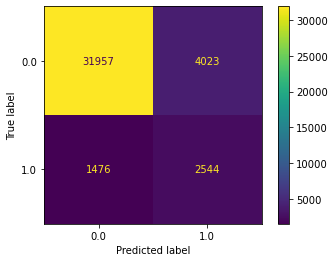

              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92     35980
         1.0       0.39      0.63      0.48      4020

    accuracy                           0.86     40000
   macro avg       0.67      0.76      0.70     40000
weighted avg       0.90      0.86      0.88     40000

Accuracy of the model:  0.862525
Recall of the model:  0.6328358208955224
Precision of the model:  0.3873915029693924
F Measure of the model:  0.4805894020969113


In [21]:
### Testing the model on Validation set!
y_pred = model.best_estimator_.predict(X_val)

print('XGBoost Classifier - Confusion Matrix')
plot_confusion_matrix(model, X_val, y_val)
plt.show()

print(classification_report(y_val, y_pred))

print('Accuracy of the model: ',  accuracy_score(y_val, y_pred))
print('Recall of the model: ',    recall_score(y_val, y_pred))
print('Precision of the model: ', precision_score(y_val, y_pred))
print('F Measure of the model: ', f1_score(y_val, y_pred))

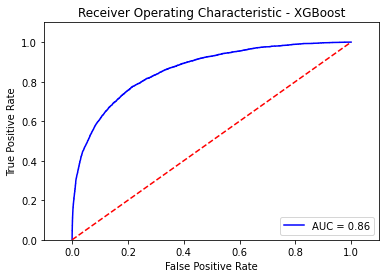

In [22]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_val)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# xgbc_clf = GridSearchCV(estimator= xgbc, param_grid = xgbc_grid, scoring = 'roc_auc', cv = inner_cv)

# xgbc_scores =  cross_val_score(xgbc_clf, X = X_train, y = y_train, cv = outer_cv)
# xgbc_score = xgbc_scores.mean()

### Sheetal - (RandomForest & DT)

In [ ]:
# Doing feature selection using random forest

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

In [ ]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(X_train.columns, clf.feature_importances_):
    print(feature)

('var_1', 0.004728940936155121)
('var_2', 0.0048685827119862414)
('var_3', 0.004699474272138594)
('var_4', 0.005105104732201353)
('var_5', 0.00495885151328344)
('var_6', 0.004961894088736823)
('var_7', 0.004997593274992777)
('var_8', 0.0044772168720684565)
('var_9', 0.005020167557016025)
('var_10', 0.004624481979062134)
('var_11', 0.004644170519319499)
('var_12', 0.004792594513971455)
('var_13', 0.004882889728569602)
('var_14', 0.004786334423727088)
('var_15', 0.004678685394095466)
('var_16', 0.004859811416222975)
('var_17', 0.004718913121113227)
('var_18', 0.004784646461772836)
('var_19', 0.004678606104287526)
('var_20', 0.004837271560257885)
('var_21', 0.004853270267695927)
('var_22', 0.005011373847667885)
('var_23', 0.004863452666383857)
('var_24', 0.00498914089579009)
('var_25', 0.004973832980887479)
('var_26', 0.004539294002595656)
('var_27', 0.005024498297243036)
('var_28', 0.004924693027035109)
('var_29', 0.004749544386608901)
('var_30', 0.005020858572622117)
('var_31', 0.004808

In [ ]:
# Decision Tree
tree_para = {'criterion':['entropy'],'max_depth': np.arange(5, 10)}


dt_clf = GridSearchCV(DecisionTreeClassifier(), tree_para,scoring = scoring , cv= inner_cv)
score = cross_val_score(dt_clf, X=X_train,y=y_train,cv = outer_cv)
dt_clf.fit(X_train, y_train) 

print('Best Parameters:',dt_clf.best_params_)

print("%0.3f accuracy with a standard deviation of %0.3f" % (score.mean(), score.std()),"\n")

In [ ]:
# Random Forest

tree_para = {'max_depth': np.arange(3, 15)}



dt_rf = GridSearchCV(RandomForestClassifier(), tree_para,scoring = scoring , cv= inner_cv)
score = cross_val_score(dt_rf, X=X_train,y=y_train,cv = outer_cv)
dt_rf.fit(X_train, y_train) 

print('Best Parameters:',dt_rf.best_params_)

print("%0.3f negative mean squared error with standard deviation of %0.3f" % (score.mean(), score.std()),"\n")


KeyboardInterrupt: ignored